This example is the same as Example 5 except we cut to the chase and show plots

In [1]:
using NLOptControl
using Polynomials
using Plots
using Parameters
#pgfplots()
pyplot()
#plotlyjs()
#default(guidefont = font(10), tickfont = font(8), legendfont = font(6), titlefont = font(10))

Plots.PyPlotBackend()


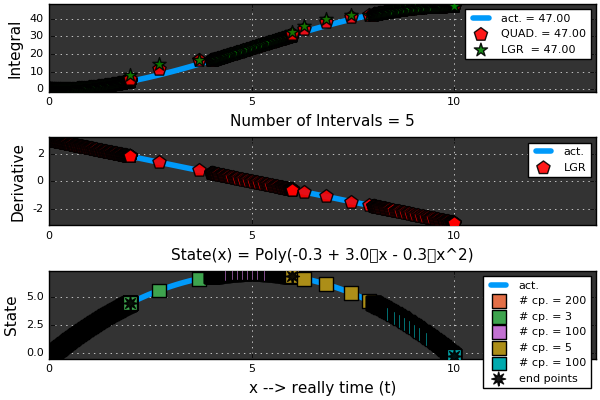

In [8]:
############
# TEST DATA
############
t0 = Float64(0); tf = Float64(10);
t = Array(linspace(t0,tf,100));
α₁ =  -0.3; α₂ = 3; α₃ = -8; α₄ =  7;

# state # 1
γ = Poly([α₁,α₂,α₁]); #TODO check on that imported binding warning
y = polyval(γ,t);

# evaluate the integral
∫γ = polyint(γ);
Y = polyval(∫γ,t[end]) - polyval(∫γ,t[1]);
C = Y - polyval(∫γ,t[end]); # constant of integration
∫y = polyval(∫γ,t) + C;

# evaluate the derivative
dγ = polyder(γ);
dy = polyval(dγ,t);
############
# TEST DATA
############
ps, nlp = initialize_NLP(numStates=1,numControls=1,Ni=5,Nck=[200,3,100,5,100]);
@pack ps = t0, tf;  # given in problem def.
@unpack Nck, Ni, t0, tf, τ, ω = ps;
di, tm, ts, ωₛ = create_intervals(t0,tf,Ni,Nck,τ,ω);
@pack ps = τ, ω, ωₛ, ts;
generate_Fake_data(nlp,ps,γ);
nlp2ocp(nlp,ps);

@unpack stateMatrix = ps;
@unpack numStates = nlp;

# interpolate function using Lagrange Polynomial
P = [zeros(Float64,Nck[int]+1,numStates) for int in 1:Ni];
for st in 1:numStates
    for int in 1:Ni
        P[int][:,st] = interpolate_lagrange(ts[int],ts[int],stateMatrix[int][1:end,st],Nck[int])
    end
end

# approximate integral using quadrature
ζ, approx_int_st = integrate_state(ps,nlp)

# calculate LGR matrices - > IMatrix and DMatrix
LGR_matrices(ps,nlp)

# approximate integral using LGRIM
ζ2, approx_int_st2 = integrate_state(ps,nlp;(:mode=>:LGRIM))

# approximate derivative using LGRDM
dζ = differentiate_state(ps,nlp)
#################
# post processing
#################
ls = 1.35;
lw = 4;

ip=plot(0,leg=:false)
plot!(t,∫y,label=@sprintf("act. = %0.2f",∫y[end]),w=lw); legend_bool = 1;
for st in 1:1
    for int in 1:Ni
        if legend_bool == 1
            scatter!(ts[int][1:end-1],ζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),leg=:bottomright,label=@sprintf("QUAD. = %0.2f",approx_int_st[st]))
            scatter!(ts[int][1:end-1],ζ2[int][st,1:Nck[int]], marker = (:star5, 10, 0.9, :green),leg=:bottomright,label=@sprintf("LGR  = %0.2f",approx_int_st2[st]))
        else # do not show legend a bunch of times
            scatter!(ts[int][1:end-1],ζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),leg=:bottomright,label= "",leg=true)
            scatter!(ts[int][1:end-1],ζ2[int][st,1:Nck[int]], marker = (:star5, 10, 0.9, :green),leg=:bottomright,label= "",leg=true)
        end
        legend_bool = 0;
    end
end
xlims!(t0,tf*ls)
ylabel!("Integral")
xlabel!(string("Number of Intervals = ", Ni))

dp=plot(0,leg=:false)
plot!(t,dy,label="act.",w=lw); legend_bool = 1;
for st in 1:1
    for int in 1:Ni
        if legend_bool == 1
            scatter!(ts[int][1:end-1],dζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),label=string("LGR"),leg=:bottomright)
        else # do not show legend a bunch of times
            scatter!(ts[int][1:end-1],dζ[int][st,1:Nck[int]],marker = (:pentagon, 10, 0.9, :red),label= "",leg=true)
        end
        legend_bool = 0;
    end
end
xlims!(t0,tf*ls)
ylabel!("Derivative")
xlabel!(string("State(x) = ",γ))

tF = zeros(Float64,Ni); yF =  zeros(Float64,Ni);
fp=plot(0,leg=:false);
plot!(t,y,label="act.",w=lw)
for st in 1:1  # currently the second state is all zeros
    for int in 1:Ni
        scatter!(ts[int],P[int][:,st],markersize =10,markershape = :rect,leg=:topright,label=string("# cp. = ",Nck[int]))
        tF[int] = ts[int][end];
        yF[int] = P[int][end,st];
    end
end
scatter!(tF,yF,markersize = 10,marker = (:star8, 10, 0.9, :black),label=string("end points"))
xlims!(t0,tf*ls)
ylabel!("State")
xlabel!("x --> really time (t)")

plot(ip,dp,fp,layout=(3,1),background_color_subplot=RGB(0.2,0.2,0.2), background_color_legend=RGB(1,1,1))
plot!(foreground_color_grid=RGB(1,1,1))

In [7]:
# resize to save
xlims!(t0,tf*1.01)
plot!(titlefont=font(14),guidefont=font(14),tickfont=font(12),legendfont=font(12))
plot!(leg=:best)
plot!(size=(700,850))
savefig("test2c.png")